# Time series II
Cenying (Tracy) Yang (cenying.yang@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

这些代码是在Python中导入所需的库和模块，包括：

pandas：用于数据处理和分析的Python库。

numpy：用于数值计算的Python库。

sklearn：用于机器学习的Python库。

scipy：用于科学计算的Python库。

statsmodels：用于统计建模和计量经济学的Python库。

matplotlib：用于数据可视化的Python库。

导入这些库和模块后，可以使用它们的功能来处理和分析数据、建立统计模型以及进行数据可视化等操作。

%matplotlib inline 是IPython的一个魔法命令，用于在Jupyter Notebook中显示图形结果。它会在Notebook中内联绘制图形，而不是在单独的窗口中显示

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
%matplotlib inline

## 1. Heater demand

In [ ]:
heater = pd.read_csv('heater.csv')
print(heater.head())
# seasonal pattern

  year_month  demand
0    2004-01      27
1    2004-02      18
2    2004-03      14
3    2004-04      13
4    2004-05      13


Text(0.5, 1.0, 'Monthly heater demand')

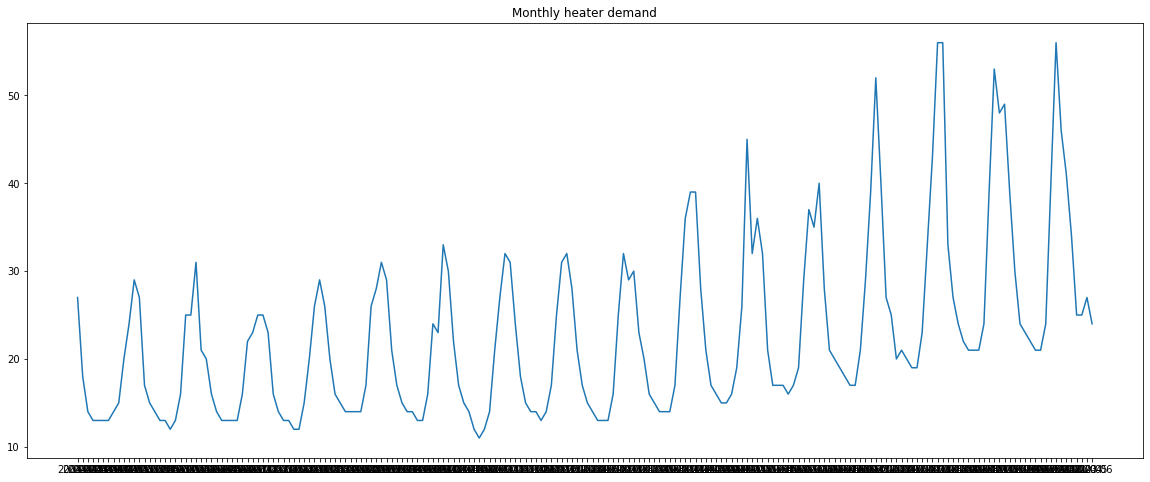

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand']) # plt.plot() 第一个参数通常被指定为x轴数据
plt.title('Monthly heater demand')

### Is the time series stationary? 

#### No. The data has an increasing trend and variance, and seasonal patterns. Let's confirm with the KPSS test.
不。数据具有增加的趋势和方差以及季节性模式。让我们通过 KPSS 测试进行确认。

这段代码的作用是对 heater['demand'] 序列进行 KPSS 单位根检验，并打印出检验结果中的 p-value。

kpss() 函数的第一个参数 heater['demand'] 是需要进行 KPSS 单位根检验的序列数据，第二个参数 regression='c' 指定进行检验时要加上常数项，第三个参数 nlags='auto' 则让函数自动选择滞后阶数。函数的返回值有四个变量，由于我们只需要 p-value，因此可以使用占位符 _ 和 __ 来忽略其他变量。

最后，将 p-value 以字符串的形式输出到屏幕上。

KPSS测试：kpss_stat, p_value, lags, crit = kpss(data, regression='c', nlags='auto')

In [ ]:
_, pval, __, ___ = kpss(heater['demand'], regression = 'c', nlags = 'auto')
# c: constant
print('p Value to the KPSS test is: ',pval)

p Value to the KPSS test is:  0.01


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


#### Because p-value is below 0.05, we consider the time series as non-stationary at a confidence level of 95%. 
assignment2 也有一个类似问题，要回答是因为below 0.05

#### (a) Apply Box-Cox to stabilize the variance. 

Box-Cox转换是一种常用的数据变换技术，用于改变数据分布的形态，使其更符合一些基本的统计分析假设。Box-Cox转换可以将任意正数数据集映射到一个新的数据集，新的数据集可以更接近于正态分布，从而提高了统计分析的准确性。 

这段代码使用了 Python 的 scipy 库中的 boxcox() 函数，对一个名为 heater 的数据集进行了 Box-Cox 转换，并打印出了前10个转换后的数据，以及最优的 $\lambda$ 值。

In [ ]:
BCheater, lmbda = boxcox(heater['demand'])  # 进行 Box-Cox 转换
print(BCheater[:10])  # 打印前10个转换后的数据
print(lmbda)  # 打印最优的 lambda 值

[1.33645176 1.28437989 1.24430878 1.23115726 1.23115726 1.23115726
 1.23115726 1.24430878 1.25598388 1.2992875 ]
-0.6645210955312427


Text(0.5, 1.0, 'Monthly heater demand after Box-Cox transformation')

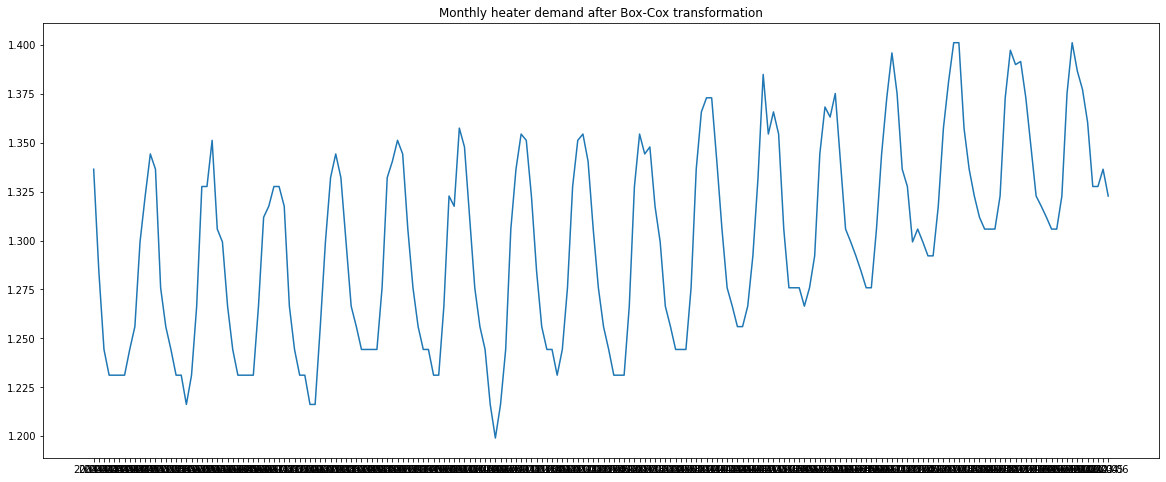

In [ ]:
# 使用Python绘制了经过Box-Cox变换后的每月加热器需求量的折线图

# 将经过Box-Cox变换的需求量数据存储在名为 BCheater 的变量中，并将其添加为 heater DataFrame的一个新列 demand_BC
heater['demand_BC'] = BCheater

# 使用 matplotlib 库创建一个新的绘图窗口，并将其大小设置为 (20,8) 英寸
plt.figure(figsize = (20,8))

# 使用 plt.plot 函数创建一个折线图。横轴为 heater DataFrame中名为 year_month 的列数据，纵轴为经过Box-Cox变换后的需求量 demand_BC
plt.plot(heater['year_month'], heater['demand_BC'])

# 折线图的标题为“经过Box-Cox变换后的每月加热器需求量”
plt.title('Monthly heater demand after Box-Cox transformation')
# alleviate a little

#### The issue of increasing variance is alleviated. The time series data exhibits increasing trend and seasonality.  差异增加的问题得到缓解。时间序列数据呈增加趋势和季节性。

#### (b) Subtract monthly average to de-seasonality.  减去月平均值以减去季节性。

将 heater DataFrame 中的 year_month 列转换为 datetime 类型，并将每个日期的月份提取出来并存储在新的 month 列中。

pd.to_datetime(heater['year_month'], format = '%Y-%m')：使用 pd.to_datetime 函数将 heater DataFrame 的 year_month 列转换为 datetime 类型。其中，format 参数告诉函数日期的格式是年-月

.dt.month：使用 dt 属性访问 datetime 类型的数据，并提取出每个日期的月份

heater['month'] = ...：将新的 month 列添加到 heater DataFrame 中，并将其中的数据设置为每个日期的月份

print(heater.head())：打印 heater DataFrame 的前几行，以检查新的 month 列是否添加成功

In [ ]:
heater['month'] = pd.to_datetime(heater['year_month'], format = '%Y-%m').dt.month
print(heater.head())

  year_month  demand  demand_BC  month
0    2004-01      27   1.336452      1
1    2004-02      18   1.284380      2
2    2004-03      14   1.244309      3
3    2004-04      13   1.231157      4
4    2004-05      13   1.231157      5


计算了每个月加热器需求量的平均值，并将结果存储在名为 heater_by_month 的新 DataFrame 中

heater.groupby('month')：使用 groupby 函数按照 month 列对 heater DataFrame 进行分组，将每个月的数据聚合到一起。

['demand_BC']：指定对 demand_BC 列进行聚合。

.mean()：使用 mean 函数计算每组中 demand_BC 列的平均值。

.reset_index()：将 heater DataFrame 的索引重置为默认值（即整数索引），并将 month 列变成了 heater_by_month DataFrame 的一列。这样，每个月的加热器需求量的平均值就被存储在了 heater_by_month DataFrame 中的 demand_BC 列中。

最终，heater_by_month DataFrame 中包含了每个月的加热器需求量的平均值，以及每个月的月份信息

In [ ]:
heater_by_month = heater.groupby('month')['demand_BC'].mean().reset_index()
print(heater_by_month.head())

   month  demand_BC
0      1   1.354655
1      2   1.323694
2      3   1.292226
3      4   1.272576
4      5   1.265195


将 DataFrame heater_by_month 中名为 demand_BC 的列重命名为 demand_month_avg

使用了 rename 函数，将一个字典作为参数传递给该函数，字典的键是原列名，值是新列名。在这里，字典的键为 'demand_BC'，值为 'demand_month_avg'。这个操作对 DataFrame 的原有列名没有任何影响，只是对副本进行修改。

在 Python 中，字典是一种键值对（key-value pair）的数据结构，用于存储和管理一组数据。字典中每个键（key）必须是唯一的，而每个键对应一个值（value）。在这段代码中，字典的作用是将旧的列名 'demand_BC' 映射为新的列名 'demand_month_avg'，并将其传递给 rename 函数。具体来说，这个字典的键是 'demand_BC'，表示需要重命名的原列名；而对应的值是 'demand_month_avg'，表示新的列名。rename 函数会根据这个字典将 DataFrame 的列名进行修改。

In [ ]:
heater_by_month = heater_by_month.rename(columns = {'demand_BC':'demand_month_avg'})
print(heater_by_month.head())

   month  demand_month_avg
0      1          1.354655
1      2          1.323694
2      3          1.292226
3      4          1.272576
4      5          1.265195


这段代码使用 merge 函数将 heater DataFrame 和 heater_by_month DataFrame 合并在一起。这个操作的实现是在 'month' 这个列上进行的，即将 heater DataFrame 和 heater_by_month DataFrame 中 'month' 列相同的行合并在一起，生成一个新的 DataFrame。

on = 'month' 参数指定了合并操作的依据是 'month' 列。这个参数告诉 merge 函数在执行合并操作时，要将 heater DataFrame 和 heater_by_month DataFrame 中 'month' 列相同的行合并在一起。

在 merge 函数中，on 参数可以指定多个列名，用一个列表或元组来指定。例如，如果 heater 和 heater_by_month 这两个 DataFrame 都有 month 和 year 两列，可以这样指定合并操作的依据：

heater = heater.merge(heater_by_month, on = ['month', 'year'])

这将 heater 和 heater_by_month 这两个 DataFrame 中 month 和 year 列的值都相同的行合并在一起


In [ ]:
heater = heater.merge(heater_by_month, on = 'month')
print(heater.head())

  year_month  demand  demand_BC  month  demand_month_avg
0    2004-01      27   1.336452      1          1.354655
1    2005-01      27   1.336452      1          1.354655
2    2006-01      21   1.305845      1          1.354655
3    2007-01      25   1.327616      1          1.354655
4    2008-01      26   1.332175      1          1.354655


这段代码使用 sort_values 函数对 heater DataFrame 按照 'year_month' 列进行排序。'year_month' 列包含了按照年份和月份排序后的日期信息。

sort_values('year_month') 函数执行后，原先无序的 heater DataFrame 中的行会按照 'year_month' 列的值进行排序，生成一个新的 DataFrame。而原来的 heater DataFrame 会被排序后的新DataFrame替换

In [ ]:
# sort data by year_month in ascending order
heater = heater.sort_values('year_month')
print(heater.head())

   year_month  demand  demand_BC  month  demand_month_avg
0     2004-01      27   1.336452      1          1.354655
17    2004-02      18   1.284380      2          1.323694
34    2004-03      14   1.244309      3          1.292226
51    2004-04      13   1.231157      4          1.272576
68    2004-05      13   1.231157      5          1.265195


在 heater DataFrame 中添加了一个名为 demand_de_season 的新列，它的值为 demand_BC 减去 demand_month_avg。这个新列表示 demand_BC 去除了季节性的影响。

Text(0.5, 1.0, 'Monthly heater demand after Box-Cox transformation and de-seasonality')

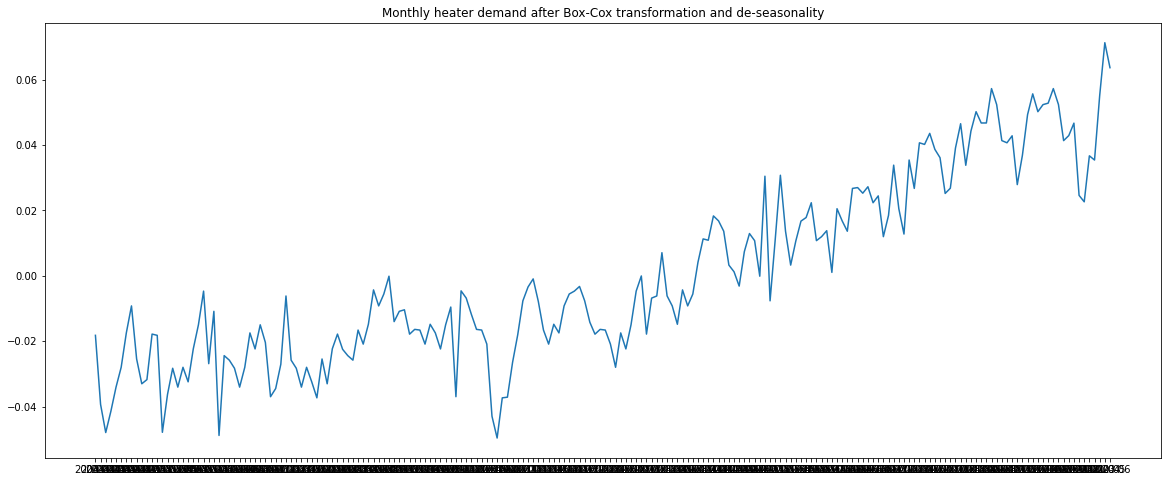

In [ ]:
# 在 heater DataFrame 中添加了一个名为 demand_de_season 的新列，值为 demand_BC 减去 demand_month_avg。新列表示 demand_BC 去除了季节性的影响。
heater['demand_de_season'] = heater['demand_BC'] - heater['demand_month_avg']

plt.figure(figsize = (20,8))

# 横轴是 year_month 列的值，表示时间，纵轴是 demand_de_season 列的值，表示去除了季节性的加热需求
plt.plot(heater['year_month'], heater['demand_de_season'])

# 表示这张图显示了经过 Box-Cox 变换和去除季节性后的加热需求。
plt.title('Monthly heater demand after Box-Cox transformation and de-seasonality')

#### The seasonality is removed. The time series data has an increasing trend. 

#### (c) Apply 1st order differencing to de-trend the data.  应用一阶差分来消除数据的趋势

In [ ]:
# 在 heater DataFrame 中添加了一个名为 demand_diff1 的新列，值是 demand_de_season 列的一阶差分，即当前行的 demand_de_season 减去上一行的 demand_de_season
heater['demand_diff1'] = heater['demand_de_season'].diff()
print(heater.head())

# pay attention to the first NaN

# 这里使用了 Pandas 中的 diff 函数，它计算每个元素与它前面一个元素之间的差值
# 由于 diff 函数计算的是一阶差分，所以在 demand_diff1 列的第一行会有一个缺失值（NaN）。

   year_month  demand  demand_BC  month  demand_month_avg  demand_de_season  \
0     2004-01      27   1.336452      1          1.354655         -0.018203   
17    2004-02      18   1.284380      2          1.323694         -0.039314   
34    2004-03      14   1.244309      3          1.292226         -0.047917   
51    2004-04      13   1.231157      4          1.272576         -0.041419   
68    2004-05      13   1.231157      5          1.265195         -0.034038   

    demand_diff1  
0            NaN  
17     -0.021111  
34     -0.008603  
51      0.006498  
68      0.007382  


Text(0.5, 1.0, 'Monthly heater demand after Box-Cox transformation, de-seasonality, and de-trend')

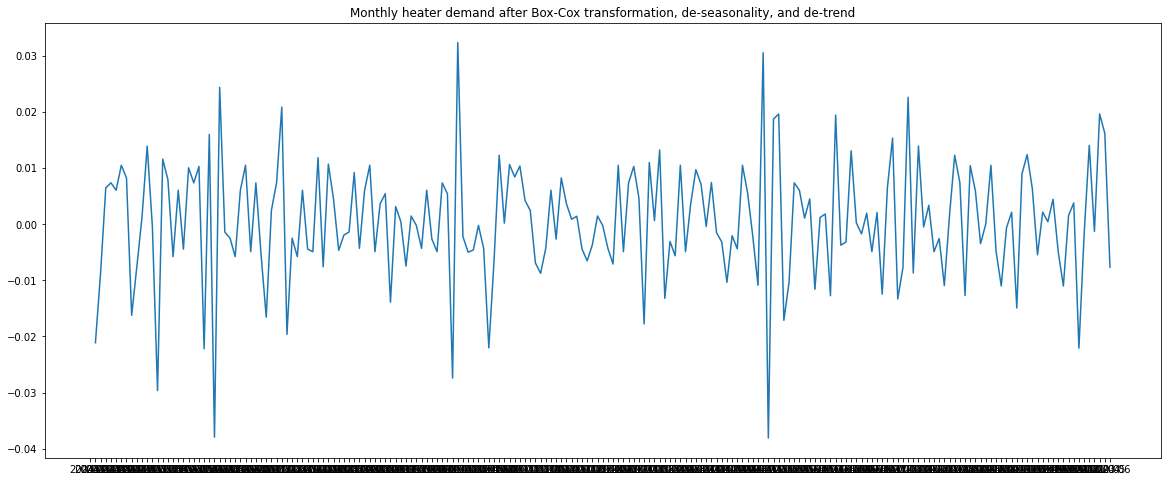

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand_diff1'])
plt.title('Monthly heater demand after Box-Cox transformation, de-seasonality, and de-trend')

#### Looks much better. Let's confirm with the KPSS test.

这段代码调用了 Python 中的 kpss 函数，并计算了 demand_diff1 列的 KPSS 检验的 p 值。

KPSS 检验用于检验一系列时间序列数据是否平稳。在这里，我们对 demand_diff1 序列进行 KPSS 检验以判断它是否平稳。该函数的第一个参数是需要进行检验的数据，即 heater DataFrame 的 demand_diff1 列。注意由于 demand_diff1 列的第一行是缺失值，因此这里将第一行去掉了。

函数的 regression 参数指定了回归模型的类型。这里指定为 'c' 表示使用常数项回归模型，即趋势为常数。nlags 参数表示使用的滞后阶数，这里指定为 'auto' 表示自动选择滞后阶数。

在函数的返回值中，使用了下划线来表示不需要的变量。由于 kpss 函数的返回值是一个元组，其中包含了 KPSS 检验的统计量和 p 值等信息，因此使用 _ 来表示不需要的统计量和信息。

最后，使用 print 函数输出 p 值，以便于进一步判断序列的平稳性

In [ ]:
_, pval, __, ___ = kpss(heater['demand_diff1'][1:], regression = 'c', nlags = 'auto') # do not include the first NaN value
print('p Value to the KPSS test is: ',pval)

# [1:]是因为第一个值不用

p Value to the KPSS test is:  0.1


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


#### Because p-value is above 0.05, we consider the time series as stationary at a confidence level of 95%. Now, we are ready to apply an ARMA model. 

#### (a) Use PACF plot to find out the order (i.e., p) of autoregression (AR).  使用 PACF 图找出自回归 （AR） 的顺序（即 p）

plot_pacf 是一个函数，可以用来画出时间序列的偏自相关图（Partial Autocorrelation Plot），描述的是在控制其他阶数的情况下，一个时间点与前面各个时间点之间的相关性。

PACF 表示在一个时间点与前面的时间点之间的相关性时，已经减去了其他阶数对它们之间相关性的影响。这使得 PACF 是一个有用的工具，可用于识别 AR（自回归）模型的阶数。

在这里，heater['demand_diff1'][1:] 是时间序列数据的一阶差分，作为函数的输入参数。title = 'PACF plot' 表示图的标题为 “PACF plot”。

需要导入 from statsmodels.graphics.tsaplots import plot_pacf 才能使用该函数

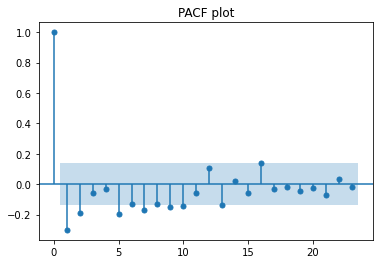

In [ ]:
plot_pacf(heater['demand_diff1'][1:], title = 'PACF plot')

#### Set p = 2. Simpler model is preferred. 

#### (b) Use ACF plot to find out the order (i.e., q) of moving average (MA). 

plot_acf 是一个函数，用于绘制时间序列的自相关函数（ACF）图。ACF 可以用来确定时间序列中不同滞后阶数之间的相关性。

heater['demand_diff1'][1:]：需要绘制自相关函数图的时间序列数据。

title='ACF plot'：设置绘图的标题

一阶差分指的是计算一个序列中每个元素和它前面一个元素的差值，以得到一个新的序列。计算方法：

假设原始序列为 y = [y_1, y_2, ..., y_n]，那么一阶差分序列为 y' = [y_2-y_1, y_3-y_2, ..., y_n-y_{n-1}]

例如，对于原始序列 y = [1, 4, 6, 9, 12]，它的一阶差分序列为 y' = [4-1, 6-4, 9-6, 12-9] = [3, 2, 3, 3]

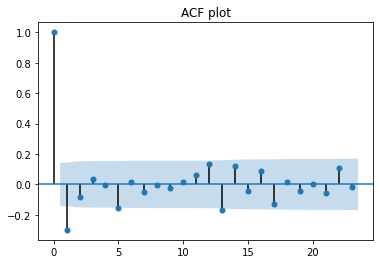

In [ ]:
plot_acf(heater['demand_diff1'][1:], title = 'ACF plot')
# start from 0

#### Set q = 1. 

#### Now, we are ready to train an ARMA(2,1)

In [ ]:
# first split our data into training and test. let's take the last 12 data points as our test data.
train = heater[:-12]
test = heater[-12:]

# 这行代码输出的是两个元组，第一个元组是 train DataFrame 的行数和列数，第二个元组是 test DataFrame 的行数和列数。
train.shape, test.shape

((186, 7), (12, 7))

Text(0.5, 1.0, 'Monthly heater demand')

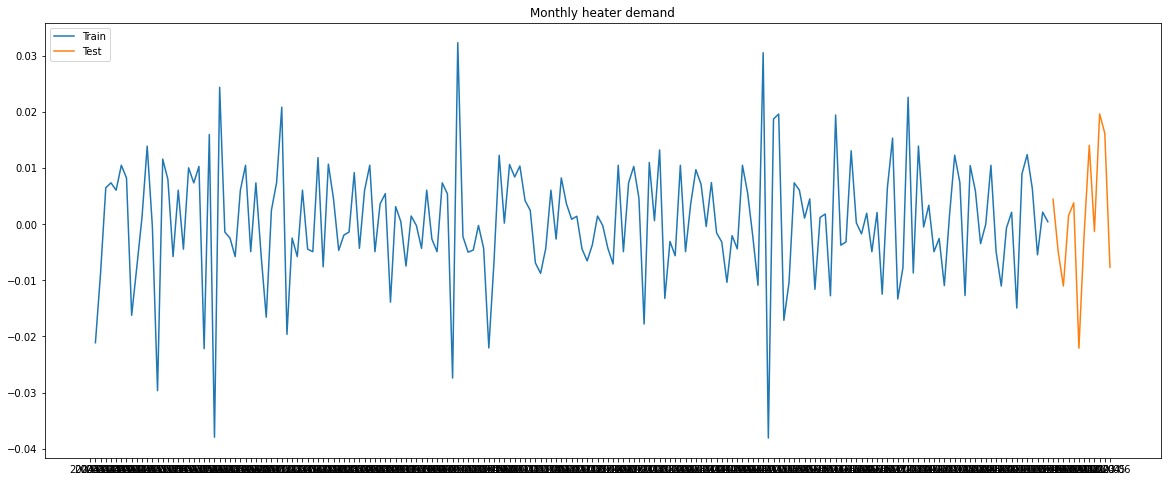

In [ ]:
# plot training and testing data
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_diff1'], label = 'Train')
plt.plot(test['year_month'], test['demand_diff1'], label = 'Test')
plt.legend(loc = 'upper left')
plt.title('Monthly heater demand')

这段代码使用ARIMA模型进行时间序列预测。

首先，我们定义了一个ARIMA模型，其中order参数被设置为(2,0,1)。这个参数指定了模型的p、d和q值，p为自回归项的阶数，d为差分的阶数，q为移动平均项的阶数。

然后，我们使用训练数据拟合ARIMA模型，即调用model.fit()函数，并将结果保存在model_fit中。

最后，我们使用model_fit.forecast()函数对测试集进行预测，预测未来12个月的需求变化量，并将结果保存在y_predict中。

需要注意的是，在进行ARIMA模型预测之前已经对原始时间序列进行了一阶差分，所以这里的d值为0

In [ ]:
# 2,0,1 ARIMA Model
model = ARIMA(train['demand_diff1'], order=(2,0,1))
model_fit = model.fit()
y_predict = model_fit.forecast(12)

# p=2, q=1
# order=(2,0,1): 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


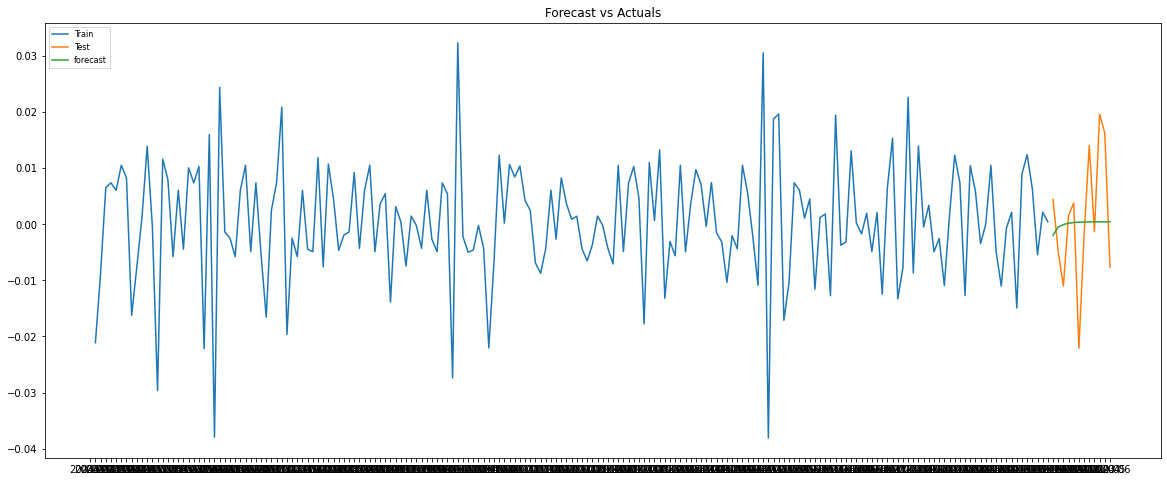

In [ ]:
# Plot
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_diff1'], label = 'Train')
plt.plot(test['year_month'], test['demand_diff1'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Let's also try ARIMA(2,1,1) model on de-season demand. 

这段代码是使用ARIMA模型对训练数据集进行拟合和预测。具体的解释如下：

ARIMA是一个可以对时间序列进行拟合和预测的类。

ARIMA(p,d,q)中，p是自回归项的阶数，表示用前p个时间点的值来预测当前时间点的值；d是差分的阶数，表示将原始序列进行d阶差分后才能使其平稳；q是移动平均项的阶数，表示用前q个时间点的误差项的加权和来预测当前时间点的值。

model = ARIMA(train['demand_de_season'], order=(2,1,1))：创建一个ARIMA模型对象，其中模型使用训练集去除了季节性的影响后的时间序列train['demand_de_season']和指定的ARIMA参数order进行拟合。order=(2,1,1)参数指定了ARIMA模型中的p、d、q。

model_fit = model.fit()进行ARIMA模型的训练。

y_predict = model_fit.forecast(12)使用已训练好的模型对测试集的未来12个月的需求进行预测，其中model_fit.forecast(12)会返回12个预测值。

In [ ]:
model = ARIMA(train['demand_de_season'], order=(2,1,1)) 
# 之前是train['demand_diff1']
model_fit = model.fit()
y_predict = model_fit.forecast(12)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


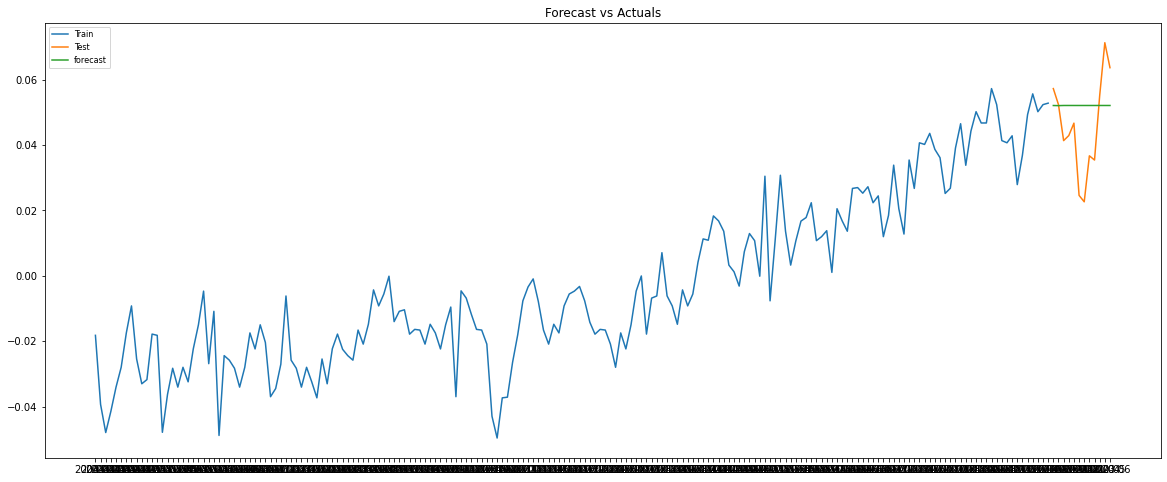

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_de_season'], label = 'Train')
plt.plot(test['year_month'], test['demand_de_season'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Let's try seasonal ARIMA on Box-Cox transformed demand. The non-seasonal part is the same as before, i.e., p = 2, d = 1, and q = 1.

#### Because the season is at month level. We take difference with lag = 12 to examine seasonal AR (P), I (D), and MA (Q). For instance, demand in January this year minus demand in January last year.  因为季节是月级别的。我们采用滞后 = 12 的差异来检查季节性 AR (P)、I (D) 和 MA (Q)。例如，今年一月的需求减去去年一月的需求。

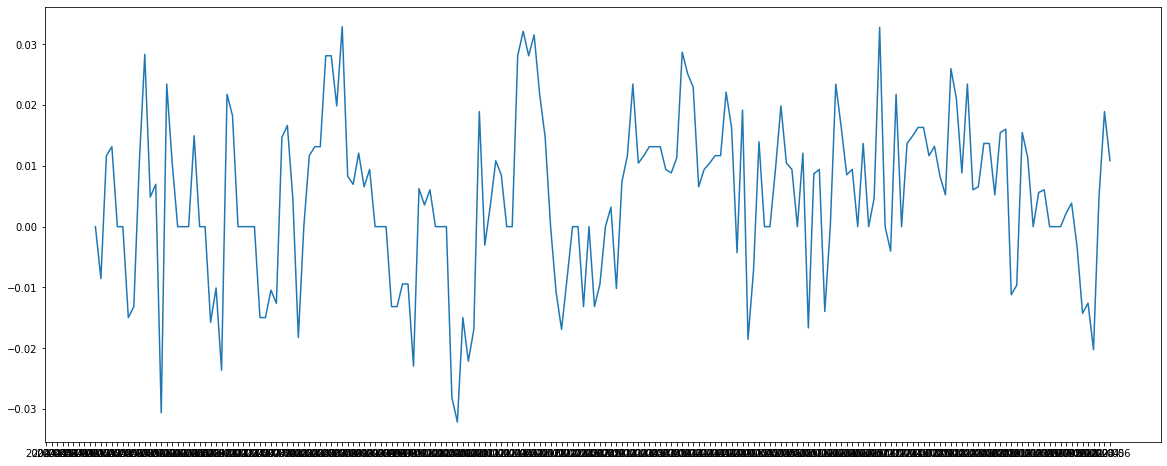

In [ ]:
# plot the demand after differencing with lag = 12
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand_BC'].diff(12))
plt.show()

#### The plot has no trend. So we do not take difference further, i.e., D = 0.

#### Use pacf to find seasonal P. P = 1. 

这段代码实现了季节性差分（即按12个月的周期进行差分），并展示了季节性差分后的数据的 PACF 图

heater['demand_BC'].diff(12) 对原始数据按12个月周期进行差分，即将当前时间点的值减去12个月前的时间点的值。

.head(n=20) 展示差分后的前20个值。

plot_pacf(heater['demand_BC'].diff(12)[12:]) 绘制季节性差分后的数据（去除前12个NaN值）的 PACF 图，用于判断 AR(p) 模型中 p 的取值。

0           NaN
17          NaN
34          NaN
51          NaN
68          NaN
85          NaN
102         NaN
118         NaN
134         NaN
150         NaN
166         NaN
182         NaN
1      0.000000
18    -0.008535
35     0.011675
52     0.013152
69     0.000000
86     0.000000
103   -0.014951
119   -0.013152
Name: demand_BC, dtype: float64


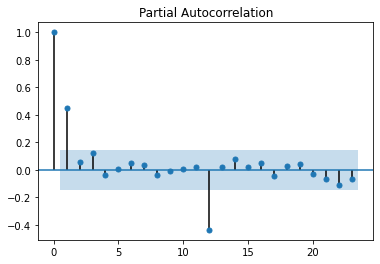

In [ ]:
print(heater['demand_BC'].diff(12).head(n=20))
plot_pacf(heater['demand_BC'].diff(12)[12:])
# set p=1, because the first lag is significant???

#### Use acf to find seasonal Q. Q = 3.

不是很懂，怎么看出3的？？？

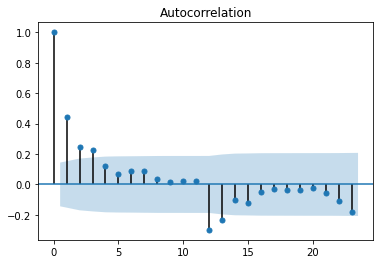

In [ ]:
plot_acf(heater['demand_BC'].diff(12)[12:]);

#### Now, we are ready to apply seasonal ARIMA model. 

使用季节性ARIMA模型来对训练集的demand_BC时间序列进行拟合和预测，其中：

order=(2,1,1)指定了ARIMA模型的p、d、q参数，表示AR项阶数为2，差分阶数为1，MA项阶数为1。

seasonal_order=(1,0,3,12)指定了季节性ARIMA模型的P、D、Q、m参数，分别为1、0、3、12，表示季节性AR项阶数为1，季节性差分阶数为0，季节性MA项阶数为3，季节长度为12个月。

model_fit = model.fit()用训练集数据拟合模型。

y_predict = model_fit.forecast(12)使用拟合好的模型进行未来12个月的预测。

ARIMA模型中，p代表AR模型的阶数，d代表原始时间序列的差分阶数，q代表MA模型的阶数。
而季节性ARIMA模型（SARIMA）则考虑了时间序列在特定季节的周期性，它包含了ARIMA模型的三个参数（p、d、q），以及另外三个描述季节性的参数：季节性自回归阶数（P）、季节性差分阶数（D）和季节性移动平均项阶数（Q）。其中，季节性自回归阶数（P）代表季节性AR模型的阶数，季节性差分阶数（D）代表季节性差分的阶数，季节性移动平均项阶数（Q）代表季节性MA模型的阶数

季节性ARIMA模型的P、D、Q参数与ARIMA模型中的p、d、q参数类似，但它们对季节性进行了建模，即考虑了同一季节内的相关性，并对数据进行了季节性差分。季节性差分可以是除去同一季节内前一年的相应时期的数值

In [ ]:
model = ARIMA(train['demand_BC'], order=(2,1,1), seasonal_order = (1,0,3,12))
model_fit = model.fit()
y_predict = model_fit.forecast(12)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa

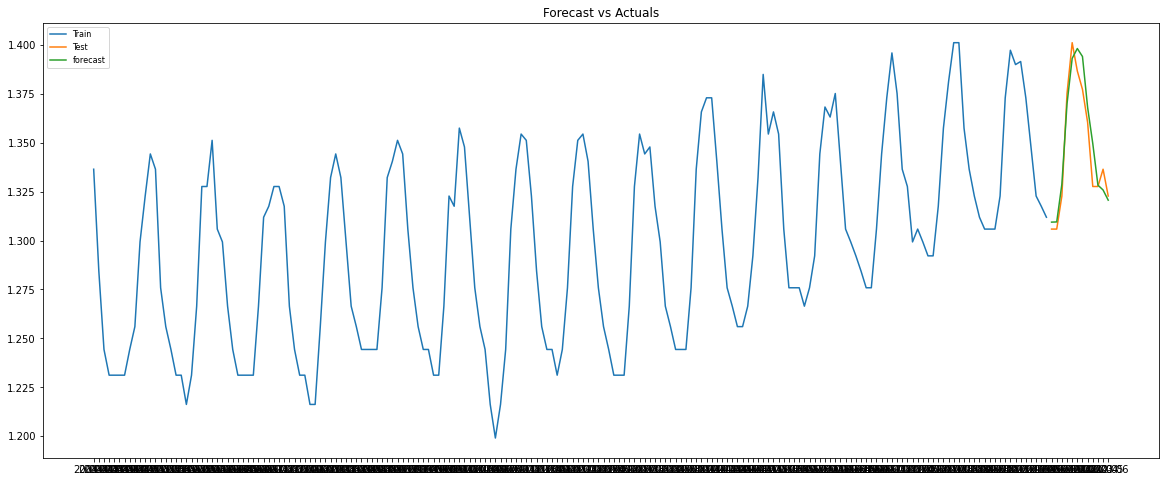

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_BC'], label = 'Train')
plt.plot(test['year_month'], test['demand_BC'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
rmse_sarima = metrics.mean_squared_error(y_pred=y_predict,
                                       y_true=test['demand_BC'], squared = False)
print(rmse_sarima)

0.010118880457220142


In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
hw = ETSModel(train['demand_BC'], trend='add', seasonal = 'add', seasonal_periods = 12)
hw_fit = hw.fit()
y_predict = hw_fit.forecast(12)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


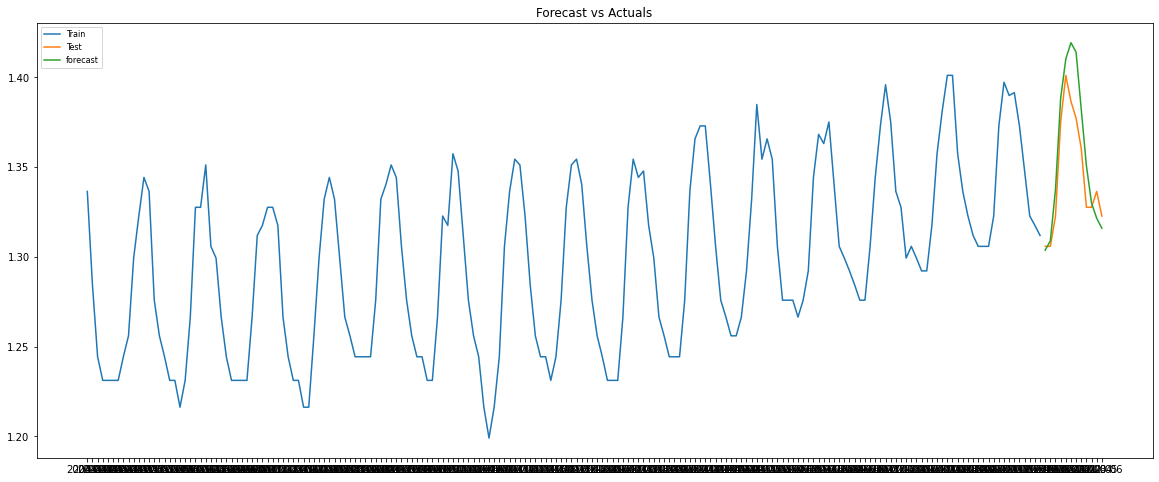

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_BC'], label = 'Train')
plt.plot(test['year_month'], test['demand_BC'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
rmse_hw = metrics.mean_squared_error(y_pred=y_predict,
                                       y_true=test['demand_BC'], squared = False)
print(rmse_hw)

0.01870499677941763
